# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

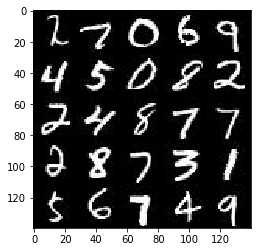

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

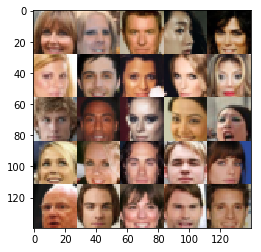

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


/home/lpalum/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x28
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x56
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*56))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.0 
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*56)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 56))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x56 now
        
        x2 = tf.layers.conv2d_transpose(x1, 112, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x112 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    print(learning_rate,beta1)
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):  
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

0.001 0.9
Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()

    samples, losses = [], []
    steps = 0
    
    #print(data_shape, learning_rate)

    tf.reset_default_graph()

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    print(lr)
    
    #with tf.Session() as sess:
    #    sess.run(lr, feed_dict={lr: float(learning_rate)})
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                #print(batch_images.shape, input_real.shape)
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 64, input_z, data_shape[3], data_image_mode)

        #saver.save(sess, './checkpoints/generator.ckpt')

    #with open('samples.pkl', 'wb') as f:
    #    pkl.dump(samples, f)
    
    return losses, samples               
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Tensor("learning_rate:0", dtype=float32)
Tensor("learning_rate:0", dtype=float32) 0.5
Epoch 1/2... Discriminator Loss: 2.4127... Generator Loss: 0.1516
Epoch 1/2... Discriminator Loss: 2.0310... Generator Loss: 0.2974
Epoch 1/2... Discriminator Loss: 1.7753... Generator Loss: 0.4966
Epoch 1/2... Discriminator Loss: 1.5241... Generator Loss: 0.6957
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 0.6675
Epoch 1/2... Discriminator Loss: 1.4676... Generator Loss: 0.6191
Epoch 1/2... Discriminator Loss: 1.4707... Generator Loss: 0.5868
Epoch 1/2... Discriminator Loss: 1.4189... Generator Loss: 0.6511
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 0.7276
Epoch 1/2... Discriminator Loss: 1.3072... Generator Loss: 0.6984


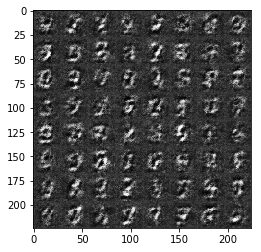

Epoch 1/2... Discriminator Loss: 1.2816... Generator Loss: 0.7099
Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 0.6633
Epoch 1/2... Discriminator Loss: 1.3348... Generator Loss: 0.6183
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 0.6665
Epoch 1/2... Discriminator Loss: 1.2079... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.2448... Generator Loss: 0.7441
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 0.7073
Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 0.6968
Epoch 1/2... Discriminator Loss: 1.2477... Generator Loss: 0.6604
Epoch 1/2... Discriminator Loss: 1.2554... Generator Loss: 0.9244


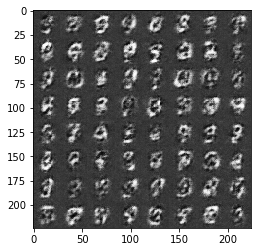

Epoch 1/2... Discriminator Loss: 1.2027... Generator Loss: 0.8332
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.7740
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 0.6247
Epoch 1/2... Discriminator Loss: 1.2420... Generator Loss: 0.8490
Epoch 1/2... Discriminator Loss: 1.2364... Generator Loss: 0.7568
Epoch 1/2... Discriminator Loss: 1.1834... Generator Loss: 1.0139
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 0.8883
Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 0.8088
Epoch 1/2... Discriminator Loss: 1.1804... Generator Loss: 0.9562
Epoch 1/2... Discriminator Loss: 1.1345... Generator Loss: 0.8239


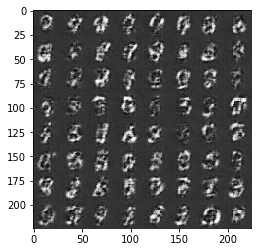

Epoch 1/2... Discriminator Loss: 1.1596... Generator Loss: 0.7496
Epoch 1/2... Discriminator Loss: 1.1589... Generator Loss: 0.8255
Epoch 1/2... Discriminator Loss: 1.1688... Generator Loss: 0.7308
Epoch 1/2... Discriminator Loss: 1.1714... Generator Loss: 0.6063
Epoch 1/2... Discriminator Loss: 1.1383... Generator Loss: 1.0177
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.8382
Epoch 1/2... Discriminator Loss: 1.0588... Generator Loss: 1.0813
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 1.0746... Generator Loss: 0.8685
Epoch 1/2... Discriminator Loss: 1.1108... Generator Loss: 0.7587


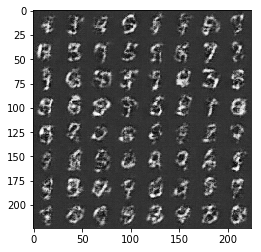

Epoch 1/2... Discriminator Loss: 1.1157... Generator Loss: 0.8003
Epoch 1/2... Discriminator Loss: 1.0768... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.0551... Generator Loss: 0.9122
Epoch 1/2... Discriminator Loss: 1.1120... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 0.6782
Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 0.7578
Epoch 1/2... Discriminator Loss: 1.0792... Generator Loss: 0.9513
Epoch 1/2... Discriminator Loss: 1.0002... Generator Loss: 1.0110
Epoch 1/2... Discriminator Loss: 1.1083... Generator Loss: 1.0760
Epoch 1/2... Discriminator Loss: 1.1368... Generator Loss: 0.5834


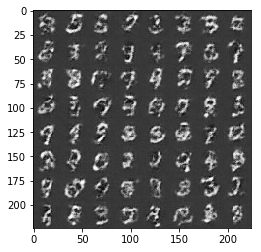

Epoch 1/2... Discriminator Loss: 1.1678... Generator Loss: 0.5538
Epoch 1/2... Discriminator Loss: 1.0477... Generator Loss: 0.7504
Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 0.9811
Epoch 1/2... Discriminator Loss: 1.0177... Generator Loss: 0.8774
Epoch 1/2... Discriminator Loss: 1.0487... Generator Loss: 0.9120
Epoch 1/2... Discriminator Loss: 1.0833... Generator Loss: 1.3501
Epoch 1/2... Discriminator Loss: 1.0217... Generator Loss: 0.8351
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 0.5081
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 0.5837
Epoch 1/2... Discriminator Loss: 1.1241... Generator Loss: 0.6156


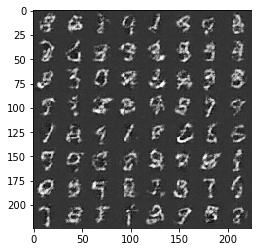

Epoch 1/2... Discriminator Loss: 1.0519... Generator Loss: 0.7759
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 0.5989
Epoch 1/2... Discriminator Loss: 1.0788... Generator Loss: 1.0900
Epoch 1/2... Discriminator Loss: 1.2272... Generator Loss: 0.5264
Epoch 1/2... Discriminator Loss: 0.9348... Generator Loss: 1.2421
Epoch 1/2... Discriminator Loss: 0.9256... Generator Loss: 1.0503
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 0.6158
Epoch 1/2... Discriminator Loss: 1.0675... Generator Loss: 0.6342
Epoch 1/2... Discriminator Loss: 1.0755... Generator Loss: 1.0101
Epoch 1/2... Discriminator Loss: 1.1161... Generator Loss: 0.6144


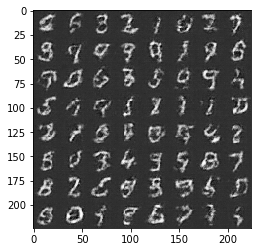

Epoch 1/2... Discriminator Loss: 1.0393... Generator Loss: 0.8421
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 0.5655
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 0.9952
Epoch 1/2... Discriminator Loss: 0.9368... Generator Loss: 1.1375
Epoch 1/2... Discriminator Loss: 1.0803... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 0.9413
Epoch 1/2... Discriminator Loss: 0.9739... Generator Loss: 0.9826
Epoch 1/2... Discriminator Loss: 1.2178... Generator Loss: 0.4891
Epoch 1/2... Discriminator Loss: 1.0236... Generator Loss: 1.1400
Epoch 1/2... Discriminator Loss: 0.9319... Generator Loss: 0.9474


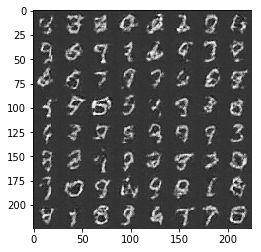

Epoch 1/2... Discriminator Loss: 1.0326... Generator Loss: 0.8080
Epoch 1/2... Discriminator Loss: 1.1101... Generator Loss: 0.6730
Epoch 1/2... Discriminator Loss: 1.1957... Generator Loss: 0.5163
Epoch 1/2... Discriminator Loss: 1.1561... Generator Loss: 0.5458
Epoch 1/2... Discriminator Loss: 1.0462... Generator Loss: 0.6824
Epoch 1/2... Discriminator Loss: 0.9601... Generator Loss: 0.8098
Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 0.9350
Epoch 1/2... Discriminator Loss: 1.0300... Generator Loss: 0.7169
Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 0.4804
Epoch 1/2... Discriminator Loss: 1.0199... Generator Loss: 1.3170


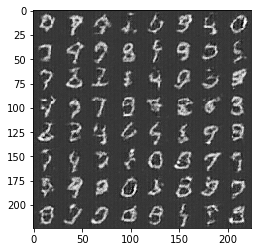

Epoch 1/2... Discriminator Loss: 1.1023... Generator Loss: 0.5329
Epoch 1/2... Discriminator Loss: 1.0268... Generator Loss: 1.3916
Epoch 1/2... Discriminator Loss: 0.9952... Generator Loss: 0.8126
Epoch 2/2... Discriminator Loss: 1.0565... Generator Loss: 0.6494
Epoch 2/2... Discriminator Loss: 0.9848... Generator Loss: 0.7260
Epoch 2/2... Discriminator Loss: 0.9802... Generator Loss: 1.1438
Epoch 2/2... Discriminator Loss: 0.8903... Generator Loss: 1.1839
Epoch 2/2... Discriminator Loss: 1.0282... Generator Loss: 0.7126
Epoch 2/2... Discriminator Loss: 0.9683... Generator Loss: 1.1444
Epoch 2/2... Discriminator Loss: 0.9909... Generator Loss: 0.7206


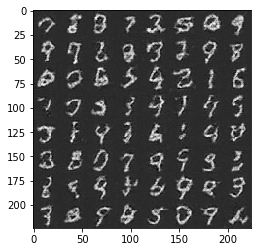

Epoch 2/2... Discriminator Loss: 1.0899... Generator Loss: 0.6087
Epoch 2/2... Discriminator Loss: 1.2478... Generator Loss: 0.4358
Epoch 2/2... Discriminator Loss: 0.9132... Generator Loss: 0.9044
Epoch 2/2... Discriminator Loss: 1.1637... Generator Loss: 0.5021
Epoch 2/2... Discriminator Loss: 1.4158... Generator Loss: 0.3553
Epoch 2/2... Discriminator Loss: 0.9178... Generator Loss: 0.9142
Epoch 2/2... Discriminator Loss: 0.9095... Generator Loss: 1.4154
Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 0.9493
Epoch 2/2... Discriminator Loss: 0.9656... Generator Loss: 0.8661
Epoch 2/2... Discriminator Loss: 0.9025... Generator Loss: 1.0660


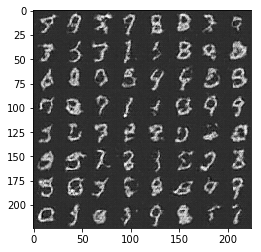

Epoch 2/2... Discriminator Loss: 1.1234... Generator Loss: 0.6267
Epoch 2/2... Discriminator Loss: 0.9489... Generator Loss: 0.8859
Epoch 2/2... Discriminator Loss: 1.0166... Generator Loss: 0.7409
Epoch 2/2... Discriminator Loss: 1.1795... Generator Loss: 0.4917
Epoch 2/2... Discriminator Loss: 0.9358... Generator Loss: 0.9830
Epoch 2/2... Discriminator Loss: 1.0158... Generator Loss: 0.8641
Epoch 2/2... Discriminator Loss: 0.8328... Generator Loss: 1.2741
Epoch 2/2... Discriminator Loss: 0.9060... Generator Loss: 1.1914
Epoch 2/2... Discriminator Loss: 1.1513... Generator Loss: 0.5471
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 0.5410


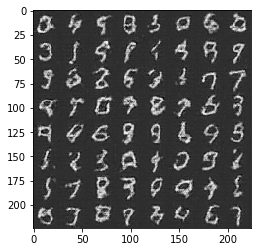

Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 0.8968
Epoch 2/2... Discriminator Loss: 0.9683... Generator Loss: 1.0303
Epoch 2/2... Discriminator Loss: 1.0364... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 0.9004
Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 1.0473
Epoch 2/2... Discriminator Loss: 0.8679... Generator Loss: 1.2257
Epoch 2/2... Discriminator Loss: 0.9476... Generator Loss: 0.6855
Epoch 2/2... Discriminator Loss: 0.9380... Generator Loss: 1.4148
Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 0.6775
Epoch 2/2... Discriminator Loss: 1.0530... Generator Loss: 0.5820


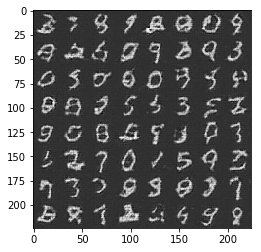

Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 0.6719
Epoch 2/2... Discriminator Loss: 0.9935... Generator Loss: 0.7963
Epoch 2/2... Discriminator Loss: 0.8414... Generator Loss: 0.9104
Epoch 2/2... Discriminator Loss: 0.8487... Generator Loss: 1.4099
Epoch 2/2... Discriminator Loss: 0.8787... Generator Loss: 1.1875
Epoch 2/2... Discriminator Loss: 0.7774... Generator Loss: 1.1261
Epoch 2/2... Discriminator Loss: 0.8512... Generator Loss: 1.0744
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 0.8070
Epoch 2/2... Discriminator Loss: 1.1757... Generator Loss: 0.4782
Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 1.2606


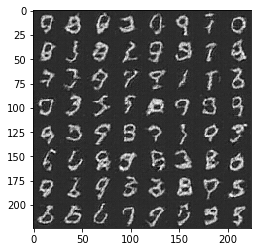

Epoch 2/2... Discriminator Loss: 0.9338... Generator Loss: 0.9305
Epoch 2/2... Discriminator Loss: 1.1033... Generator Loss: 0.5572
Epoch 2/2... Discriminator Loss: 0.7690... Generator Loss: 1.4366
Epoch 2/2... Discriminator Loss: 0.9528... Generator Loss: 0.7526
Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 0.5965
Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 1.7031
Epoch 2/2... Discriminator Loss: 0.7621... Generator Loss: 1.3414
Epoch 2/2... Discriminator Loss: 1.2784... Generator Loss: 0.4273
Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 0.8701
Epoch 2/2... Discriminator Loss: 0.9825... Generator Loss: 0.6791


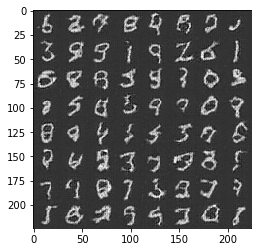

Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 0.9014
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.0009
Epoch 2/2... Discriminator Loss: 1.0479... Generator Loss: 0.6298
Epoch 2/2... Discriminator Loss: 0.8977... Generator Loss: 1.4618
Epoch 2/2... Discriminator Loss: 0.7861... Generator Loss: 1.7995
Epoch 2/2... Discriminator Loss: 0.8600... Generator Loss: 0.9208
Epoch 2/2... Discriminator Loss: 0.8666... Generator Loss: 1.0793
Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 0.8658
Epoch 2/2... Discriminator Loss: 1.1690... Generator Loss: 0.4913
Epoch 2/2... Discriminator Loss: 1.0083... Generator Loss: 0.7198


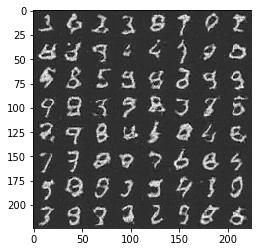

Epoch 2/2... Discriminator Loss: 1.2069... Generator Loss: 0.4568
Epoch 2/2... Discriminator Loss: 0.9636... Generator Loss: 0.7426
Epoch 2/2... Discriminator Loss: 0.9956... Generator Loss: 0.6573
Epoch 2/2... Discriminator Loss: 1.1386... Generator Loss: 0.5557
Epoch 2/2... Discriminator Loss: 0.8480... Generator Loss: 1.4154
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 1.2647
Epoch 2/2... Discriminator Loss: 1.1752... Generator Loss: 0.4948
Epoch 2/2... Discriminator Loss: 0.9904... Generator Loss: 1.5683
Epoch 2/2... Discriminator Loss: 0.9535... Generator Loss: 0.7504
Epoch 2/2... Discriminator Loss: 0.7436... Generator Loss: 1.4497


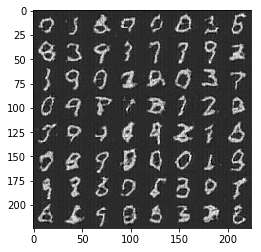

Epoch 2/2... Discriminator Loss: 0.8816... Generator Loss: 0.8160
Epoch 2/2... Discriminator Loss: 1.0270... Generator Loss: 0.6115
Epoch 2/2... Discriminator Loss: 0.8633... Generator Loss: 0.9809
Epoch 2/2... Discriminator Loss: 0.9907... Generator Loss: 0.6389
Epoch 2/2... Discriminator Loss: 0.9510... Generator Loss: 0.7029
Epoch 2/2... Discriminator Loss: 1.0168... Generator Loss: 0.6038
Epoch 2/2... Discriminator Loss: 0.7807... Generator Loss: 1.1566
Epoch 2/2... Discriminator Loss: 0.9003... Generator Loss: 1.4761
Epoch 2/2... Discriminator Loss: 0.7668... Generator Loss: 1.1360
Epoch 2/2... Discriminator Loss: 1.0970... Generator Loss: 0.5525


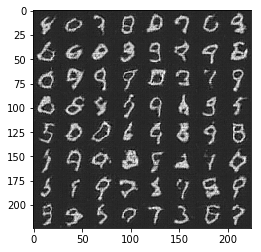

Epoch 2/2... Discriminator Loss: 0.8518... Generator Loss: 0.8783
Epoch 2/2... Discriminator Loss: 0.9946... Generator Loss: 0.8459
Epoch 2/2... Discriminator Loss: 1.0334... Generator Loss: 0.6461
Epoch 2/2... Discriminator Loss: 0.8141... Generator Loss: 0.9354
Epoch 2/2... Discriminator Loss: 1.1636... Generator Loss: 0.4831
Epoch 2/2... Discriminator Loss: 0.9064... Generator Loss: 0.7265
Epoch 2/2... Discriminator Loss: 0.8003... Generator Loss: 1.0883


IndexError: list index out of range

In [23]:
# Hyperparameters from the DCGAN paper
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Tensor("learning_rate:0", dtype=float32)
Tensor("learning_rate:0", dtype=float32) 0.5
Epoch 1/1... Discriminator Loss: 2.5493... Generator Loss: 0.1361
Epoch 1/1... Discriminator Loss: 2.4464... Generator Loss: 0.1929
Epoch 1/1... Discriminator Loss: 2.5679... Generator Loss: 0.2273
Epoch 1/1... Discriminator Loss: 2.2655... Generator Loss: 0.3502
Epoch 1/1... Discriminator Loss: 2.0477... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.7658... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.5715... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.5925... Generator Loss: 0.5839


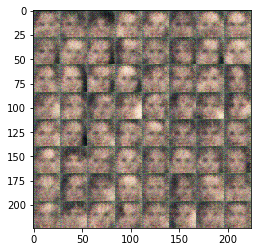

Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.6577... Generator Loss: 0.5201
Epoch 1/1... Discriminator Loss: 1.5534... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.6358... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.5944... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.6252... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.6135


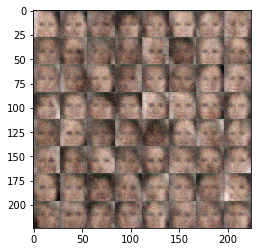

Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.5829... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.6422... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.5165... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.5566


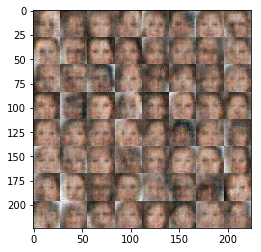

Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.6093... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.5732... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.8085


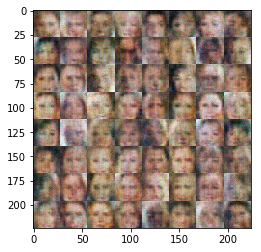

Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.4290
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 0.8137... Generator Loss: 1.4631
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.6091... Generator Loss: 0.3529
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 1.6962
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.1676
Epoch 1/1... Discriminator Loss: 0.6261... Generator Loss: 2.9008


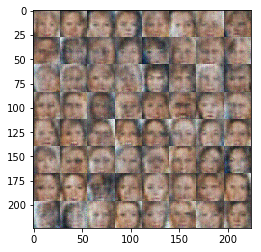

Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 3.2469
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 1.6030
Epoch 1/1... Discriminator Loss: 0.5561... Generator Loss: 2.9248
Epoch 1/1... Discriminator Loss: 0.5210... Generator Loss: 1.9345
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 2.0948
Epoch 1/1... Discriminator Loss: 0.4885... Generator Loss: 2.6338
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 0.6516... Generator Loss: 4.9878
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.3825


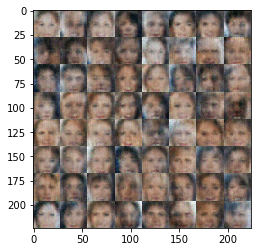

Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 5.3824
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 2.6133
Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 1.6389
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 4.5284
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.4154
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 1.7883
Epoch 1/1... Discriminator Loss: 0.5665... Generator Loss: 1.9949


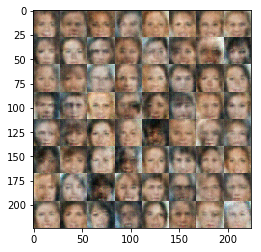

Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 0.5489... Generator Loss: 2.9836
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.6783... Generator Loss: 0.3174
Epoch 1/1... Discriminator Loss: 1.6252... Generator Loss: 0.3254
Epoch 1/1... Discriminator Loss: 1.6031... Generator Loss: 0.3500
Epoch 1/1... Discriminator Loss: 1.5859... Generator Loss: 0.3536
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.4626
Epoch 1/1... Discriminator Loss: 0.5980... Generator Loss: 1.4888
Epoch 1/1... Discriminator Loss: 0.7582... Generator Loss: 1.2561


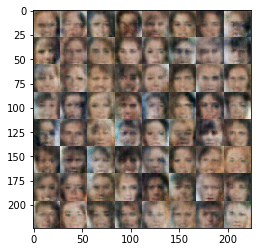

Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 1.2037
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 3.6107
Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 1.2191
Epoch 1/1... Discriminator Loss: 0.7177... Generator Loss: 1.9628
Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 2.2874
Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.0687
Epoch 1/1... Discriminator Loss: 0.5312... Generator Loss: 1.8813
Epoch 1/1... Discriminator Loss: 1.6079... Generator Loss: 0.4448
Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 2.1708
Epoch 1/1... Discriminator Loss: 1.5670... Generator Loss: 0.3426


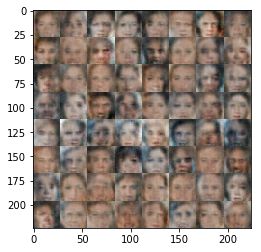

Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 2.0087
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 0.6593... Generator Loss: 2.7116
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.3863
Epoch 1/1... Discriminator Loss: 0.7461... Generator Loss: 1.6346
Epoch 1/1... Discriminator Loss: 1.6126... Generator Loss: 0.3522
Epoch 1/1... Discriminator Loss: 1.6163... Generator Loss: 0.3322
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 1.6495
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.8172


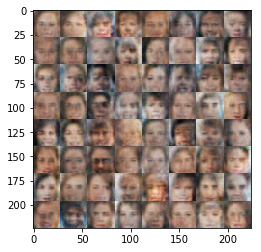

Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 2.0943
Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.3583
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.4457
Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.4853
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.3836
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.3667
Epoch 1/1... Discriminator Loss: 0.7252... Generator Loss: 1.2611


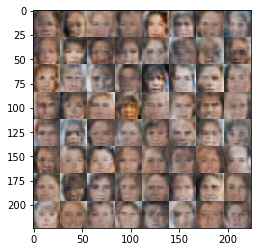

Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.4430
Epoch 1/1... Discriminator Loss: 0.7557... Generator Loss: 1.3327
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.2496
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 2.8317
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 2.3407
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.4472
Epoch 1/1... Discriminator Loss: 1.6316... Generator Loss: 0.3606
Epoch 1/1... Discriminator Loss: 0.7129... Generator Loss: 1.9544


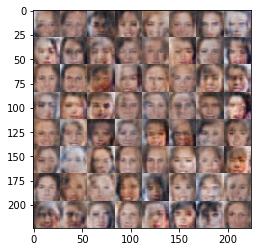

Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.1777
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.5355... Generator Loss: 0.3772
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 1.9872
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.4605
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.4600
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.0282
Epoch 1/1... Discriminator Loss: 0.6187... Generator Loss: 1.7768
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 2.0261


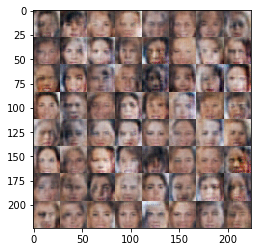

Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 1.1779
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.4493
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.4915
Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.3852
Epoch 1/1... Discriminator Loss: 0.6709... Generator Loss: 1.9262
Epoch 1/1... Discriminator Loss: 1.6201... Generator Loss: 0.3411
Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 3.3309
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.5631


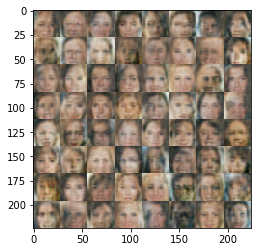

Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 1.1637
Epoch 1/1... Discriminator Loss: 0.8168... Generator Loss: 1.7370
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 1.9651
Epoch 1/1... Discriminator Loss: 0.7206... Generator Loss: 2.3983
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.4896
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.3701
Epoch 1/1... Discriminator Loss: 1.5990... Generator Loss: 0.3500
Epoch 1/1... Discriminator Loss: 0.7858... Generator Loss: 1.2778
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 1.8000


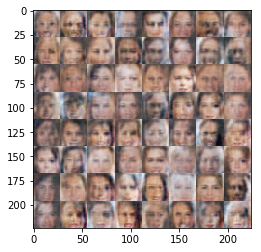

Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 0.6794... Generator Loss: 2.4176
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 1.6169
Epoch 1/1... Discriminator Loss: 0.7639... Generator Loss: 1.5128
Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 2.0817
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.3607
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 1.3361
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.4669
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.0809


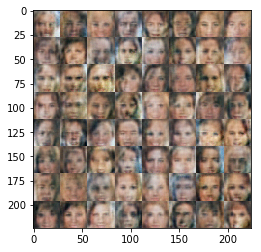

Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 1.1937
Epoch 1/1... Discriminator Loss: 0.6361... Generator Loss: 1.5166
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 1.9051
Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 1.6839
Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 0.3536
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.1343
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.4249


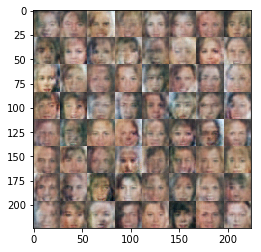

Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.7724
Epoch 1/1... Discriminator Loss: 0.8050... Generator Loss: 1.9311
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 1.3821
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 1.4063
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 2.0308
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 1.1308


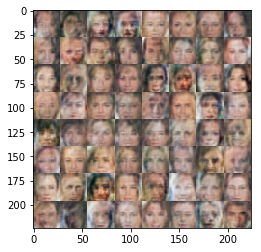

Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 1.3068
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 1.8059
Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 1.2923
Epoch 1/1... Discriminator Loss: 1.5810... Generator Loss: 0.3487
Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.3888
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 0.6490... Generator Loss: 1.3859


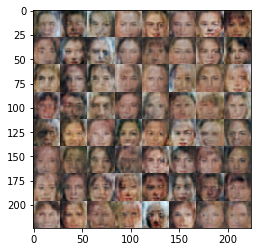

Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 1.3541
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 1.6123
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 1.0582
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 1.3732
Epoch 1/1... Discriminator Loss: 0.6927... Generator Loss: 1.4012
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 2.5742
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.5739
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.5120


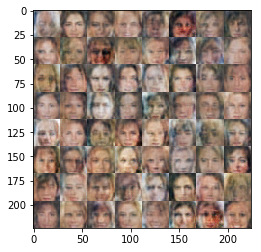

Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 1.7159
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.5291
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.4660
Epoch 1/1... Discriminator Loss: 0.7197... Generator Loss: 1.1079
Epoch 1/1... Discriminator Loss: 1.8730... Generator Loss: 0.3846
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.3540
Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 1.1889
Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 1.6531


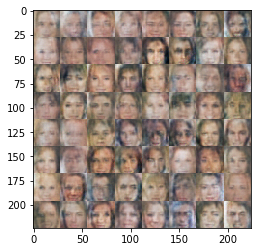

Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 1.7738
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.5045
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 2.0893
Epoch 1/1... Discriminator Loss: 0.6790... Generator Loss: 1.5178
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 1.5778
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 1.2302
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.6598
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 0.7064... Generator Loss: 1.2475


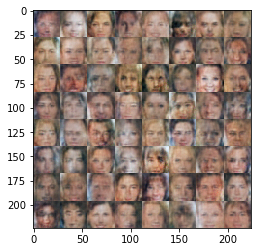

Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 0.8364... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 1.2906
Epoch 1/1... Discriminator Loss: 0.7236... Generator Loss: 1.3510
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.1752
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 1.1361
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.0429


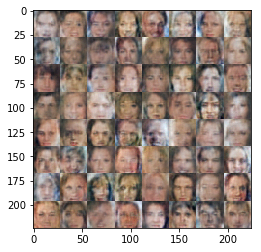

Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 1.3060
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 0.7920... Generator Loss: 1.2862
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 0.8268... Generator Loss: 1.5614
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 1.3474
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 2.1190... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 0.6189... Generator Loss: 2.6427
Epoch 1/1... Discriminator Loss: 0.8297... Generator Loss: 1.0676


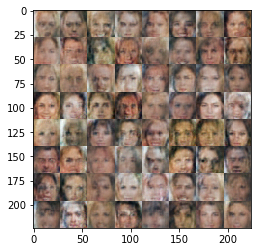

Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 1.4654
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 1.2082
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.4146
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 1.2616
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.3462
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 1.4476


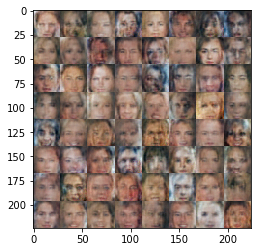

Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 1.1379
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 1.1753
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.1461
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.4026
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 1.2290
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 1.5271
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.4554


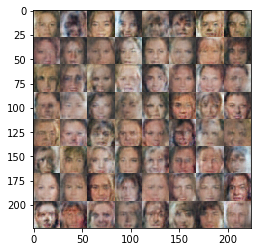

Epoch 1/1... Discriminator Loss: 0.6865... Generator Loss: 1.1895
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 1.1003
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 1.3476
Epoch 1/1... Discriminator Loss: 0.6599... Generator Loss: 1.4899
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 1.3354


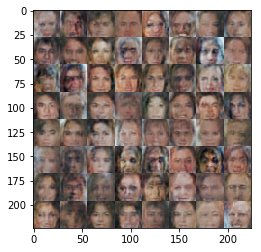

Epoch 1/1... Discriminator Loss: 0.8182... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 1.2833
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 0.4343... Generator Loss: 3.5188
Epoch 1/1... Discriminator Loss: 1.5439... Generator Loss: 0.5036
Epoch 1/1... Discriminator Loss: 0.7966... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 1.1117
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.6294


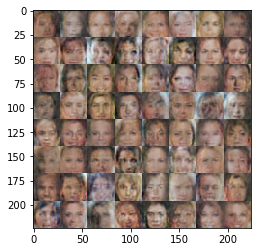

Epoch 1/1... Discriminator Loss: 0.8048... Generator Loss: 1.2406
Epoch 1/1... Discriminator Loss: 0.8221... Generator Loss: 1.2332
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 5.2958
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.0450
Epoch 1/1... Discriminator Loss: 0.8886... Generator Loss: 1.6474
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.4205
Epoch 1/1... Discriminator Loss: 1.8295... Generator Loss: 0.2529
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.4130


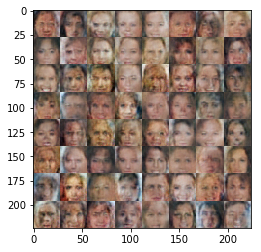

Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 1.3806
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 1.9308
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.4418
Epoch 1/1... Discriminator Loss: 0.8182... Generator Loss: 1.2474
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.0978
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 2.8280
Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 6.3106


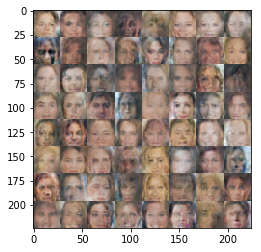

Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.8628
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 1.1672
Epoch 1/1... Discriminator Loss: 0.7770... Generator Loss: 1.4130
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 1.4862
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 0.8165... Generator Loss: 1.4548
Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 1.4399
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 1.5478


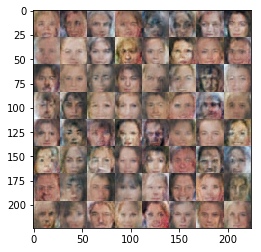

Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.6552... Generator Loss: 0.3953
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 2.0080
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 1.9257


IndexError: list index out of range

In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.